In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [12]:
company = 'TSLA'

start = dt.datetime(2012,1,1)
end = dt.datetime(2021,10,26)

data = web.DataReader(company, 'yahoo', start, end)

In [13]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
# Build The Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing value.

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
76/76 [==============================] - 11s 60ms/step - loss: 0.0032
Epoch 2/25
76/76 [==============================] - 5s 63ms/step - loss: 0.0013
Epoch 3/25
76/76 [==============================] - 5s 68ms/step - loss: 0.0014
Epoch 4/25
76/76 [==============================] - 6s 75ms/step - loss: 9.9805e-04
Epoch 5/25
76/76 [==============================] - 5s 65ms/step - loss: 9.9264e-04
Epoch 6/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0011
Epoch 7/25
76/76 [==============================] - 5s 65ms/step - loss: 8.5728e-04
Epoch 8/25
76/76 [==============================] - 5s 64ms/step - loss: 9.8383e-04
Epoch 9/25
76/76 [==============================] - 5s 61ms/step - loss: 9.0518e-04
Epoch 10/25
76/76 [==============================] - 5s 62ms/step - loss: 9.1515e-04
Epoch 11/25
76/76 [==============================] - 5s 62ms/step - loss: 7.9309e-04
Epoch 12/25
76/76 [==============================] - 5s 62ms/step - loss: 9.2323e-04
Epoc

### Test The Model Accuracy on Existing Data

In [6]:
# Load Test Data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

In [7]:
test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0) 

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [9]:
# Make Predictions on Test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

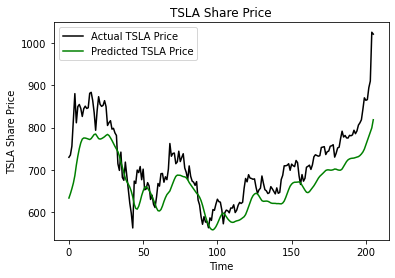

In [10]:
# Plot The Test Predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [11]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')


Prediction: [[841.8435]]
